## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random vecotr variable $\mathsf{X} \sim \pi \in \mathbb{R}^{N_x}$, based on samples of the distribution of interest.

Reference: 
* Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).
* Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.
* Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.

In [145]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter

Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-96 model is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the twent-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{20})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [3]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [124]:
# Define the distribution for initial condition
Nx = 15
# Number of runs
Ne = 5000
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 1000.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 1000.0)
u0: [2.248972047027674, 0.3921854124957878, -0.5342500540602472, -0.3339381181403215, 0.30170729464435403, -1.1636485816103919, -1.865749819373462, -2.02112706525955, 0.1771995491696815, -0.1131749032849999, 1.288040555604191, 0.5226308575306329, -1.1468656006784301, 1.065796728729853, -1.6876668896466056]

Create cache to store the different final solutions

In [125]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [126]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [127]:
m = 35
S = HermiteMap(m, X; diag = true);

The optimization proceudre takes about 5 minutes with $N_e = 4000$ samples

In [128]:
optimize(S, X, "kfold"; withqr = true, verbose = true, conditioner = false)

1 terms - Training error: 1.416940041091561, Validation error: 1.4264325016571098
1 terms - Training error: 1.4167560181809453, Validation error: 1.4271636807828745
2 terms - Training error: 1.4149786068074335, Validation error: 1.423250377570953
3 terms - Training error: 1.4139692206054288, Validation error: 1.4214065642019769
4 terms - Training error: 1.410412252505258, Validation error: 1.4145965747861582
5 terms - Training error: 1.4099228905109475, Validation error: 1.4155614551316593
6 terms - Training error: 1.4064957167006789, Validation error: 1.412093058900855
7 terms - Training error: 1.4064859992821592, Validation error: 1.4121358840476097
8 terms - Training error: 1.4057027744485118, Validation error: 1.412050838445754
9 terms - Training error: 1.4055881745383787, Validation error: 1.4122247700364166
10 terms - Training error: 1.4054139325443529, Validation error: 1.4127703570750059
11 terms - Training error: 1.4053689408022452, Validation error: 1.4126028169994271
12 term

29 terms - Training error: 1.405835941278235, Validation error: 1.4087443822121097
30 terms - Training error: 1.40583594334928, Validation error: 1.408744386473277
31 terms - Training error: 1.4058359269198308, Validation error: 1.4087443302108356
32 terms - Training error: 1.4058359169913535, Validation error: 1.408744328111648
33 terms - Training error: 1.4058359162397198, Validation error: 1.4087443255329697
34 terms - Training error: 1.4058359092922763, Validation error: 1.408744324108865
1 terms - Training error: 1.4178627908589039, Validation error: 1.4227415025877381
1 terms - Training error: 1.4178422195429268, Validation error: 1.4226175349801704
2 terms - Training error: 1.4157944977743762, Validation error: 1.4196909998714682
3 terms - Training error: 1.4144453042819112, Validation error: 1.4192233696270917
4 terms - Training error: 1.4101669419890548, Validation error: 1.4151312167343204
5 terms - Training error: 1.4099524827802214, Validation error: 1.4147796184736676
6 te

Progress:   7%|██▊                                      |  ETA: 15:03:37

9 terms - Training error: 1.406734230849046
1 terms - Training error: 1.4228964026241713, Validation error: 1.4026070555266765
1 terms - Training error: 1.4215876392488833, Validation error: 1.4019187156201134
2 terms - Training error: 1.405412379629644, Validation error: 1.383909957647724
3 terms - Training error: 1.4027369882289888, Validation error: 1.3799357264820484
4 terms - Training error: 1.3933762412349682, Validation error: 1.376574271833809
5 terms - Training error: 1.391243347268623, Validation error: 1.3757519391560218
6 terms - Training error: 1.389284265337909, Validation error: 1.3755546353444965
7 terms - Training error: 1.3890363269207715, Validation error: 1.3755142935645381
8 terms - Training error: 1.3884510277782545, Validation error: 1.373536783936635
9 terms - Training error: 1.3753001821508597, Validation error: 1.3656231655356315
10 terms - Training error: 1.3604464101578806, Validation error: 1.3596431066977421
11 terms - Training error: 1.3546584737717398, V

28 terms - Training error: 1.3394807380506082, Validation error: 1.3203214709967321
29 terms - Training error: 1.3391999954876337, Validation error: 1.3197493371322064
30 terms - Training error: 1.3391500303419164, Validation error: 1.320133262476685
31 terms - Training error: 1.3387664555948393, Validation error: 1.3194803280999838
32 terms - Training error: 1.3387655041211135, Validation error: 1.319464330091932
33 terms - Training error: 1.3387461497304867, Validation error: 1.3194815737464887
34 terms - Training error: 1.3387187216495011, Validation error: 1.319406182329958
1 terms - Training error: 1.4162253600638988, Validation error: 1.4292912257677683
1 terms - Training error: 1.4151599303651168, Validation error: 1.4276324172439678
2 terms - Training error: 1.4111467257665942, Validation error: 1.4274200037984845
3 terms - Training error: 1.388465620122869, Validation error: 1.3969510279791124
4 terms - Training error: 1.3868418318596365, Validation error: 1.3938666728441225
5

Progress:  13%|█████▌                                   |  ETA: 7:14:29

34 terms - Training error: 1.3344679762163856
1 terms - Training error: 1.4189754788628532, Validation error: 1.418290750571952
1 terms - Training error: 1.4180166050253902, Validation error: 1.4174389144219992
2 terms - Training error: 1.4140607223164545, Validation error: 1.4170667472107263
3 terms - Training error: 1.393945716371228, Validation error: 1.3973963817331336
4 terms - Training error: 1.3827337176050443, Validation error: 1.3810401570224295
5 terms - Training error: 1.3128059831074734, Validation error: 1.31296455334012
6 terms - Training error: 1.3105890728855591, Validation error: 1.3087281252619607
7 terms - Training error: 1.3097756229812687, Validation error: 1.310607090721023
8 terms - Training error: 1.3066131370337253, Validation error: 1.3080430479519465
9 terms - Training error: 1.3064296338378785, Validation error: 1.3076158978580272
10 terms - Training error: 1.305486731002312, Validation error: 1.304562213801343
11 terms - Training error: 1.3041343302761341, 

28 terms - Training error: 1.213881765820071, Validation error: 1.2299132177332741
29 terms - Training error: 1.2134882488346446, Validation error: 1.2295446061857684
30 terms - Training error: 1.2134480125301883, Validation error: 1.229178182467028
31 terms - Training error: 1.2130509945095937, Validation error: 1.2275448654536394
32 terms - Training error: 1.2102116353471326, Validation error: 1.228425299322597
33 terms - Training error: 1.210099100038613, Validation error: 1.229667416036759
34 terms - Training error: 1.2098925635563988, Validation error: 1.2298950291234136
1 terms - Training error: 1.4174131611762424, Validation error: 1.4245400213183965
1 terms - Training error: 1.4163984231559583, Validation error: 1.4239181474784592
2 terms - Training error: 1.40161089589123, Validation error: 1.4159298615523097
3 terms - Training error: 1.3992868997321892, Validation error: 1.4105046529673804
4 terms - Training error: 1.3917905536794677, Validation error: 1.4058601140232223
5 te

Progress:  20%|████████▎                                |  ETA: 4:34:53

35 terms - Training error: 1.2128351102840076
1 terms - Training error: 1.4260931491011979, Validation error: 1.389820069618575
1 terms - Training error: 1.425116177768953, Validation error: 1.3881526253657221
2 terms - Training error: 1.3995623854403798, Validation error: 1.3646950448732236
3 terms - Training error: 1.3877322885905576, Validation error: 1.3588982238667224
4 terms - Training error: 1.3855454463190298, Validation error: 1.356241526635773
5 terms - Training error: 1.3836903707136292, Validation error: 1.3526726873745638
6 terms - Training error: 1.3733839049474696, Validation error: 1.3389325555762879
7 terms - Training error: 1.307227828599112, Validation error: 1.3069972534483503
8 terms - Training error: 1.3044616955721, Validation error: 1.3041991569044367
9 terms - Training error: 1.3032450331471959, Validation error: 1.3071058662467234
10 terms - Training error: 1.3005296889330393, Validation error: 1.3010628739182581
11 terms - Training error: 1.2997078470299004, 

28 terms - Training error: 1.233027042334977, Validation error: 1.2484779684987417
29 terms - Training error: 1.2328425171789836, Validation error: 1.2487027050309758
30 terms - Training error: 1.200979314312936, Validation error: 1.217082265288407
31 terms - Training error: 1.2000647446741188, Validation error: 1.2160764925058554
32 terms - Training error: 1.1905706624338737, Validation error: 1.209034237275033
33 terms - Training error: 1.1885218072047583, Validation error: 1.207844280951362
34 terms - Training error: 1.1876721451128733, Validation error: 1.2082315963486523
1 terms - Training error: 1.4151732744530443, Validation error: 1.433499568211188
1 terms - Training error: 1.4135995772928598, Validation error: 1.4343867258455045
2 terms - Training error: 1.408100820430351, Validation error: 1.437568179025367
3 terms - Training error: 1.386018958658606, Validation error: 1.4152386138930126
4 terms - Training error: 1.371087208218555, Validation error: 1.4008390680981504
5 terms

Progress:  27%|██████████▉                              |  ETA: 3:13:50

35 terms - Training error: 1.2152544605683813
1 terms - Training error: 1.4152702143543063, Validation error: 1.4331118086061456
1 terms - Training error: 1.414117052473482, Validation error: 1.4319486036164588
2 terms - Training error: 1.3860150044421151, Validation error: 1.4172458324376327
3 terms - Training error: 1.3787332159712071, Validation error: 1.4119657246480213
4 terms - Training error: 1.3762967870759548, Validation error: 1.4096463101123133
5 terms - Training error: 1.3733339710393788, Validation error: 1.4060305731118952
6 terms - Training error: 1.3644364906770081, Validation error: 1.3934985249085787
7 terms - Training error: 1.3055179784788766, Validation error: 1.3213248356820575
8 terms - Training error: 1.3045088210770441, Validation error: 1.3191944376695852
9 terms - Training error: 1.3037684589808383, Validation error: 1.3184850476725174
10 terms - Training error: 1.3003262273446432, Validation error: 1.3176411463199804
11 terms - Training error: 1.299095524150

28 terms - Training error: 1.2283029461908828, Validation error: 1.2464792076226712
29 terms - Training error: 1.2277331654207342, Validation error: 1.2436157301276194
30 terms - Training error: 1.227529129402602, Validation error: 1.2442245517402681
31 terms - Training error: 1.225655283003578, Validation error: 1.2445635609078987
32 terms - Training error: 1.225642320093731, Validation error: 1.2443070779067291
33 terms - Training error: 1.2235838865136812, Validation error: 1.2451165047578336
34 terms - Training error: 1.2210096517506628, Validation error: 1.2424519229676276
1 terms - Training error: 1.4237243600328575, Validation error: 1.3992952258919378
1 terms - Training error: 1.421964509200493, Validation error: 1.4008718717755362
2 terms - Training error: 1.3958735555611421, Validation error: 1.3778549207130462
3 terms - Training error: 1.3880785424476327, Validation error: 1.374628294372763
4 terms - Training error: 1.3851359820970215, Validation error: 1.3745355236818741
5 

Progress:  33%|█████████████▋                           |  ETA: 2:24:13

35 terms - Training error: 1.2218031221883983
1 terms - Training error: 1.4225459116597354, Validation error: 1.4040090193844277
1 terms - Training error: 1.4211115000443157, Validation error: 1.4036186404141142
2 terms - Training error: 1.3947518094444356, Validation error: 1.369208098755473
3 terms - Training error: 1.3870145403940164, Validation error: 1.368202222292223
4 terms - Training error: 1.3847645314278834, Validation error: 1.3647111797419016
5 terms - Training error: 1.3806782731491343, Validation error: 1.365239539228118
6 terms - Training error: 1.370137960700263, Validation error: 1.3556357934013916
7 terms - Training error: 1.3078038095477371, Validation error: 1.3022304009496735
8 terms - Training error: 1.3065255737626815, Validation error: 1.2999279247860762
9 terms - Training error: 1.3057934144947014, Validation error: 1.302020421893222
10 terms - Training error: 1.3049990808566239, Validation error: 1.3006693800168623
11 terms - Training error: 1.3031853069278738

28 terms - Training error: 1.2152875823308102, Validation error: 1.2028911584039703
29 terms - Training error: 1.2148770864821867, Validation error: 1.201260145115198
30 terms - Training error: 1.2105491173179366, Validation error: 1.197587890796555
31 terms - Training error: 1.2091971263793224, Validation error: 1.1956551194279414
32 terms - Training error: 1.2080421812183961, Validation error: 1.1933837588763578
33 terms - Training error: 1.2073030251298398, Validation error: 1.1926721118786947
34 terms - Training error: 1.2072358391615483, Validation error: 1.192636392802754
1 terms - Training error: 1.4157430352082683, Validation error: 1.4312205251902936
1 terms - Training error: 1.4147391176554056, Validation error: 1.4291288189531348
2 terms - Training error: 1.3835548382318719, Validation error: 1.4143011723622625
3 terms - Training error: 1.3767349263166435, Validation error: 1.414337160507591
4 terms - Training error: 1.3743694382567884, Validation error: 1.4072366059190535
5

Progress:  40%|████████████████▍                        |  ETA: 1:49:39

35 terms - Training error: 1.2581150606621656
1 terms - Training error: 1.4167108677126423, Validation error: 1.4273491951727884
1 terms - Training error: 1.4154574314905197, Validation error: 1.4271535725167355
2 terms - Training error: 1.3933965640901351, Validation error: 1.4012242438767921
3 terms - Training error: 1.3819334598504627, Validation error: 1.392738219915473
4 terms - Training error: 1.3809865018348648, Validation error: 1.3905388756650126
5 terms - Training error: 1.3781063659802304, Validation error: 1.3900215991919893
6 terms - Training error: 1.367602680093668, Validation error: 1.3713142870346215
7 terms - Training error: 1.308224520714799, Validation error: 1.2995579500563894
8 terms - Training error: 1.3068536547976723, Validation error: 1.2966156211525635
9 terms - Training error: 1.3065774870809137, Validation error: 1.2964756215376434
10 terms - Training error: 1.3043946241298012, Validation error: 1.2927966908669304
11 terms - Training error: 1.30396786280382

29 terms - Training error: 1.2327424884324387, Validation error: 1.2325920136318276
30 terms - Training error: 1.2326485216603256, Validation error: 1.2328113591525414
31 terms - Training error: 1.230261498592974, Validation error: 1.2292485930876944
32 terms - Training error: 1.226921881476636, Validation error: 1.2238182961721924
33 terms - Training error: 1.2245886848351122, Validation error: 1.222719835985494
34 terms - Training error: 1.214457317104741, Validation error: 1.2169009315281347
1 terms - Training error: 1.4217737274048419, Validation error: 1.40709775640399
1 terms - Training error: 1.420604329568406, Validation error: 1.4065347868688691
2 terms - Training error: 1.3968007598367356, Validation error: 1.387659652955352
3 terms - Training error: 1.385666595380474, Validation error: 1.3778993751626565
4 terms - Training error: 1.3843342669455425, Validation error: 1.377160311371771
5 terms - Training error: 1.3811267378294816, Validation error: 1.378938776254479
6 terms -

Progress:  47%|███████████████████▏                     |  ETA: 1:24:29

35 terms - Training error: 1.2266598581441186
1 terms - Training error: 1.4168952583659316, Validation error: 1.426611632559635
1 terms - Training error: 1.4150901053460931, Validation error: 1.428397393557553
2 terms - Training error: 1.3886690853171273, Validation error: 1.3955859857100894
3 terms - Training error: 1.378246374844204, Validation error: 1.3896148277638778
4 terms - Training error: 1.376349301280366, Validation error: 1.389228297419649
5 terms - Training error: 1.3730948445714661, Validation error: 1.384093785340054
6 terms - Training error: 1.3706846241581916, Validation error: 1.3795968195107808
7 terms - Training error: 1.3672246918458084, Validation error: 1.3766453831612007
8 terms - Training error: 1.3123137508851523, Validation error: 1.322287293933203
9 terms - Training error: 1.3078871610609082, Validation error: 1.3156823651429705
10 terms - Training error: 1.3050823984270277, Validation error: 1.3168437842836833
11 terms - Training error: 1.3045089199134572, 

28 terms - Training error: 1.2503693028504452, Validation error: 1.2588244491972354
29 terms - Training error: 1.2500525913678016, Validation error: 1.258457291581953
30 terms - Training error: 1.2466030797925312, Validation error: 1.2534263497262095
31 terms - Training error: 1.2464042831660234, Validation error: 1.2528959338554324
32 terms - Training error: 1.2448665720705179, Validation error: 1.2501517508165427
33 terms - Training error: 1.2413569659517287, Validation error: 1.2515767682955907
34 terms - Training error: 1.2214154674923892, Validation error: 1.2369645530602058
1 terms - Training error: 1.4128955588335457, Validation error: 1.4426104306891798
1 terms - Training error: 1.4120070769535267, Validation error: 1.4442145217599707
2 terms - Training error: 1.4026570691261515, Validation error: 1.4367438856153008
3 terms - Training error: 1.373569473989346, Validation error: 1.4081244997588855
4 terms - Training error: 1.3712171184620503, Validation error: 1.409869728622496


Progress:  53%|█████████████████████▉                   |  ETA: 1:05:26

35 terms - Training error: 1.2449420971858627
1 terms - Training error: 1.4228572345135078, Validation error: 1.4027637279693368
1 terms - Training error: 1.422224775253602, Validation error: 1.403049583033915
2 terms - Training error: 1.4141662028391202, Validation error: 1.3964507049415724
3 terms - Training error: 1.4043112441041763, Validation error: 1.385379071727907
4 terms - Training error: 1.391931335366742, Validation error: 1.3716813790051032
5 terms - Training error: 1.3895686979744752, Validation error: 1.3653909781776394
6 terms - Training error: 1.3864944885522603, Validation error: 1.3605751451541879
7 terms - Training error: 1.3817169885676406, Validation error: 1.3594108917579404
8 terms - Training error: 1.314879812448845, Validation error: 1.31614108077418
9 terms - Training error: 1.3120886096368483, Validation error: 1.3162079385519416
10 terms - Training error: 1.3094330112323649, Validation error: 1.311555983254693
11 terms - Training error: 1.3050718311401015, V

28 terms - Training error: 1.249858891311546, Validation error: 1.2510114994672106
29 terms - Training error: 1.249061839159173, Validation error: 1.2491680179232285
30 terms - Training error: 1.2490174016355438, Validation error: 1.2484620933571486
31 terms - Training error: 1.2470024815746874, Validation error: 1.2510452756885138
32 terms - Training error: 1.2465257694747436, Validation error: 1.2498634154482078
33 terms - Training error: 1.2455925966245494, Validation error: 1.2466347305983032
34 terms - Training error: 1.2455292411415055, Validation error: 1.2458841990230347
1 terms - Training error: 1.4188834783463415, Validation error: 1.4186587526380048
1 terms - Training error: 1.4181845154594945, Validation error: 1.4192629588664487
2 terms - Training error: 1.410391724204409, Validation error: 1.4115842523215376
3 terms - Training error: 1.3997513537735247, Validation error: 1.403627287489855
4 terms - Training error: 1.3880771080367522, Validation error: 1.387159565560958
5 

Progress:  60%|████████████████████████▋                |  ETA: 0:50:25

35 terms - Training error: 1.244853874573416
1 terms - Training error: 1.4215722598576153, Validation error: 1.4079036265928984
1 terms - Training error: 1.4207966674186316, Validation error: 1.4094756657985335
2 terms - Training error: 1.4149048873145933, Validation error: 1.4028790351443163
3 terms - Training error: 1.387737725189097, Validation error: 1.3724869188157998
4 terms - Training error: 1.385468245647173, Validation error: 1.3698432078929217
5 terms - Training error: 1.3821204351262963, Validation error: 1.3666638310185808
6 terms - Training error: 1.3707595423703924, Validation error: 1.3589753899226893
7 terms - Training error: 1.314852842815946, Validation error: 1.3028552003366949
8 terms - Training error: 1.3132073895373688, Validation error: 1.3049078545771629
9 terms - Training error: 1.3114565369683282, Validation error: 1.3062849814137447
10 terms - Training error: 1.3110165176897344, Validation error: 1.304809941909486
11 terms - Training error: 1.309975463917531,

29 terms - Training error: 1.2891804435548213, Validation error: 1.2689886375758117
30 terms - Training error: 1.2890064194784985, Validation error: 1.268523242049953
31 terms - Training error: 1.2867745019439374, Validation error: 1.264900128246837
32 terms - Training error: 1.279479000638474, Validation error: 1.2670060981753808
33 terms - Training error: 1.2723416965560674, Validation error: 1.2546052496380073
34 terms - Training error: 1.261254126874698, Validation error: 1.2537700479866587
1 terms - Training error: 1.4125729832995557, Validation error: 1.4439007328251392
1 terms - Training error: 1.4104230268318594, Validation error: 1.4469245294268387
2 terms - Training error: 1.3847237791960072, Validation error: 1.4179851824062497
3 terms - Training error: 1.3771854242986055, Validation error: 1.4151086821963355
4 terms - Training error: 1.3746320049166523, Validation error: 1.413689473103039
5 terms - Training error: 1.3712426440783116, Validation error: 1.4106577401803229
6 t

Progress:  67%|███████████████████████████▍             |  ETA: 0:38:09

35 terms - Training error: 1.2572638922961996
1 terms - Training error: 1.4116802250105593, Validation error: 1.4474717659811223
1 terms - Training error: 1.410195368816848, Validation error: 1.4476359927026812
2 terms - Training error: 1.3897046670310795, Validation error: 1.429644109875499
3 terms - Training error: 1.3864964330357425, Validation error: 1.4276865331080126
4 terms - Training error: 1.3833845472524204, Validation error: 1.4261981676461062
5 terms - Training error: 1.3776420886549872, Validation error: 1.422754813649707
6 terms - Training error: 1.3643511625958071, Validation error: 1.412898637759742
7 terms - Training error: 1.3010153893047811, Validation error: 1.3359618708122227
8 terms - Training error: 1.2988636708814838, Validation error: 1.3349460593730653
9 terms - Training error: 1.2974914651267486, Validation error: 1.3355994737775168
10 terms - Training error: 1.2954539250854047, Validation error: 1.331409000577749
11 terms - Training error: 1.2931077456170377

28 terms - Training error: 1.2404762860843725, Validation error: 1.2690307261860045
29 terms - Training error: 1.2403905938018855, Validation error: 1.2685118181217938
30 terms - Training error: 1.2402609876274575, Validation error: 1.267672882719464
31 terms - Training error: 1.2401716728819558, Validation error: 1.2684160224291317
32 terms - Training error: 1.2393773415682232, Validation error: 1.2668566521279507
33 terms - Training error: 1.2374376148104975, Validation error: 1.2659760396336486
34 terms - Training error: 1.2345747605000639, Validation error: 1.2613187899242981
1 terms - Training error: 1.4261231046478793, Validation error: 1.3897002474318416
1 terms - Training error: 1.4248480300072948, Validation error: 1.3889400621466643
2 terms - Training error: 1.4051684561698785, Validation error: 1.3676173272067684
3 terms - Training error: 1.4025197611336824, Validation error: 1.3634588886844623
4 terms - Training error: 1.400147603278579, Validation error: 1.3590187166025007

Progress:  73%|██████████████████████████████▏          |  ETA: 0:28:01

35 terms - Training error: 1.2382082282323466
1 terms - Training error: 1.4247179804232781, Validation error: 1.3953207443302502
1 terms - Training error: 1.4235340253306465, Validation error: 1.3950806888162437
2 terms - Training error: 1.4002761390106238, Validation error: 1.3700946525062787
3 terms - Training error: 1.3906881191181912, Validation error: 1.366252821966425
4 terms - Training error: 1.3877008456414672, Validation error: 1.3638001816723606
5 terms - Training error: 1.3857147946030104, Validation error: 1.3616328173439711
6 terms - Training error: 1.376526876247979, Validation error: 1.353049206266842
7 terms - Training error: 1.3132595136287935, Validation error: 1.3122494081411356
8 terms - Training error: 1.3112477842398802, Validation error: 1.3080467567878606
9 terms - Training error: 1.3105195129550093, Validation error: 1.3053421481912328
10 terms - Training error: 1.309422082023173, Validation error: 1.3042055093707445
11 terms - Training error: 1.308863568403032

28 terms - Training error: 1.2484038115268978, Validation error: 1.2583107112986458
29 terms - Training error: 1.2453812691712296, Validation error: 1.2577696756214531
30 terms - Training error: 1.2449091517773259, Validation error: 1.2561953569288684
31 terms - Training error: 1.2434666695233667, Validation error: 1.2540736895156592
32 terms - Training error: 1.243234575177341, Validation error: 1.2539920992327542
33 terms - Training error: 1.2386297796568637, Validation error: 1.2491017909474658
34 terms - Training error: 1.2385930633886502, Validation error: 1.2491198634912979
1 terms - Training error: 1.4170681600173198, Validation error: 1.425920025954085
1 terms - Training error: 1.4161317954322032, Validation error: 1.4246590181668335
2 terms - Training error: 1.392154782649396, Validation error: 1.4025757016949472
3 terms - Training error: 1.3844816420633388, Validation error: 1.39101580079071
4 terms - Training error: 1.3818201963958234, Validation error: 1.387276736849029
5 t

Progress:  80%|████████████████████████████████▊        |  ETA: 0:19:29

34 terms - Training error: 1.2600816897259322
1 terms - Training error: 1.4173267453151523, Validation error: 1.424885684762757
1 terms - Training error: 1.4152042137497363, Validation error: 1.4289388070296585
2 terms - Training error: 1.3882562436675308, Validation error: 1.414763698323487
3 terms - Training error: 1.3808498867928845, Validation error: 1.4149297273826857
4 terms - Training error: 1.3775742968484443, Validation error: 1.411136908398405
5 terms - Training error: 1.3744635556525615, Validation error: 1.4076423982765092
6 terms - Training error: 1.3692751979950513, Validation error: 1.4063810794604712
7 terms - Training error: 1.3164559439818162, Validation error: 1.338290566729373
8 terms - Training error: 1.311534772661187, Validation error: 1.3324078644409598
9 terms - Training error: 1.3049653614916346, Validation error: 1.3257927984279565
10 terms - Training error: 1.3038060349625524, Validation error: 1.323597892493657
11 terms - Training error: 1.2999083095430313,

28 terms - Training error: 1.2928985628055036, Validation error: 1.2950172734855405
29 terms - Training error: 1.2922964428279875, Validation error: 1.2945551097723715
30 terms - Training error: 1.2922144179986708, Validation error: 1.2945464484562363
31 terms - Training error: 1.2919621619767523, Validation error: 1.2936012949924431
32 terms - Training error: 1.2735984166389267, Validation error: 1.2781320340934235
33 terms - Training error: 1.2731788138529108, Validation error: 1.2785633628873374
34 terms - Training error: 1.2714286380641058, Validation error: 1.277667853507995
1 terms - Training error: 1.4147300282878705, Validation error: 1.435272552871884
1 terms - Training error: 1.4140453108048106, Validation error: 1.4361410470773728
2 terms - Training error: 1.4082563450830952, Validation error: 1.4280482484276684
3 terms - Training error: 1.38574062484903, Validation error: 1.3916337086950024
4 terms - Training error: 1.3830453141521122, Validation error: 1.3883568657143543
5

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:12:06

35 terms - Training error: 1.2679387894902348
1 terms - Training error: 1.4218982950108456, Validation error: 1.4065994859799762
1 terms - Training error: 1.420186475428119, Validation error: 1.4095018286193963
2 terms - Training error: 1.4155441648306686, Validation error: 1.4063437208088498
3 terms - Training error: 1.3942873272912424, Validation error: 1.3956056784517366
4 terms - Training error: 1.3835105661248872, Validation error: 1.3842688610004759
5 terms - Training error: 1.376900348810094, Validation error: 1.3743474559153384
6 terms - Training error: 1.367632789429071, Validation error: 1.3622055693434034
7 terms - Training error: 1.2948211387205808, Validation error: 1.292609110983393
8 terms - Training error: 1.2929092149444108, Validation error: 1.2915930511223654
9 terms - Training error: 1.2920547389580952, Validation error: 1.2917206509887518
10 terms - Training error: 1.291721156092523, Validation error: 1.289903574746027
11 terms - Training error: 1.2909209690115762,

28 terms - Training error: 1.2382415079204803, Validation error: 1.2641946251468863
29 terms - Training error: 1.2378799346579241, Validation error: 1.2642357490065792
30 terms - Training error: 1.2191083562215972, Validation error: 1.2447341853892055
31 terms - Training error: 1.2185483634585332, Validation error: 1.2420019189716098
32 terms - Training error: 1.2146800877938402, Validation error: 1.235604878468008
33 terms - Training error: 1.2144754534805156, Validation error: 1.2361566339168555
34 terms - Training error: 1.2144145315295094, Validation error: 1.2356393373003167
1 terms - Training error: 1.4233446382177657, Validation error: 1.4008141131522982
1 terms - Training error: 1.42251360689859, Validation error: 1.3995829697226512
2 terms - Training error: 1.3979676152081495, Validation error: 1.3788055009954336
3 terms - Training error: 1.3889123554957967, Validation error: 1.3658033932935574
4 terms - Training error: 1.3861499837823277, Validation error: 1.3611933508212994


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:05:40

35 terms - Training error: 1.2163229942668592
1 terms - Training error: 1.4189365261141202, Validation error: 1.4184465615668955
1 terms - Training error: 1.4180698874854467, Validation error: 1.4163678330821345
2 terms - Training error: 1.4124814027526598, Validation error: 1.4104682105503263
3 terms - Training error: 1.3906433998970182, Validation error: 1.3811239791396073
4 terms - Training error: 1.3798650583896799, Validation error: 1.3688625310699762
5 terms - Training error: 1.3144610564409258, Validation error: 1.3009469010747001
6 terms - Training error: 1.3058520879670454, Validation error: 1.2894868351981839
7 terms - Training error: 1.301085269183642, Validation error: 1.2936880185119135
8 terms - Training error: 1.2983123747047116, Validation error: 1.2889995195262345
9 terms - Training error: 1.2971147560205873, Validation error: 1.2900136696864133
10 terms - Training error: 1.295154202407694, Validation error: 1.2901757973412546
11 terms - Training error: 1.2937706306171

28 terms - Training error: 1.2291100306057585, Validation error: 1.2119632993401552
29 terms - Training error: 1.2286798840688866, Validation error: 1.210688211578038
30 terms - Training error: 1.2286168343368689, Validation error: 1.2106551449547942
31 terms - Training error: 1.2284598788084902, Validation error: 1.2107836573036992
32 terms - Training error: 1.2268723356382119, Validation error: 1.2109196676813108
33 terms - Training error: 1.2264433313395147, Validation error: 1.2106478037756212
34 terms - Training error: 1.2240622076365988, Validation error: 1.2153772536657006
1 terms - Training error: 1.4215849945319599, Validation error: 1.4078526878955377
1 terms - Training error: 1.4200960540531877, Validation error: 1.4083091087774486
2 terms - Training error: 1.414679165328242, Validation error: 1.401690217328899
3 terms - Training error: 1.3906024062696705, Validation error: 1.3812547262226258
4 terms - Training error: 1.3812803957166913, Validation error: 1.3705803218423107


Progress: 100%|█████████████████████████████████████████| Time: 1:20:00


35 terms - Training error: 1.2200989464108067


HermiteMap(35, 15, LinearTransform(15, [2.3437789437300305, 2.3293694848335535, 2.2912568995075726, 2.3956417200038573, 2.3383282325529917, 2.2460268064389255, 2.4023611469999766, 2.3295604914837593, 2.331303351229725, 2.4076398308255293, 2.3799735560128434, 2.360155601651277, 2.260806720556231, 2.3188118282591925, 2.3966100992139325], [3.647201933771397 0.0 … 0.0 0.0; 0.0 3.6584312213587427 … 0.0 0.0; … ; 0.0 0.0 … 3.6489108349184143 0.0; 0.0 0.0 … 0.0 3.68372233963186], true), MapComponent[Map component of dimension 1 with Nψ 9 active features
, Map component of dimension 2 with Nψ 34 active features
, Map component of dimension 3 with Nψ 35 active features
, Map component of dimension 4 with Nψ 35 active features
, Map component of dimension 5 with Nψ 35 active features
, Map component of dimension 6 with Nψ 35 active features
, Map component of dimension 7 with Nψ 35 active features
, Map component of dimension 8 with Nψ 35 active features
, Map component of dimension 9 with Nψ 35 

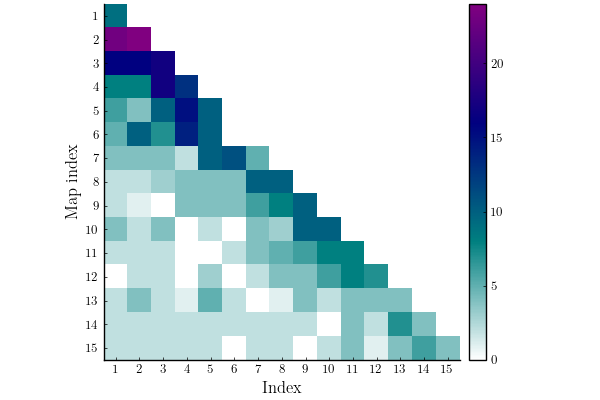

In [131]:
plot(S)
# savefig("Lorenz96_structure.pdf")

<cite>Baptista et al.[1]</cite> showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \int_{\math
\end{equation}


[1] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.

In [99]:
We can measure the conditional indepen

LoadError: [91msyntax: extra token "can" after end of expression[39m

In [146]:
Ω = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ω .+= copy(cache[1,:,:]).^2
end
rmul!(Ω, 1/Ne)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:15


15×15 Array{Float64,2}:
      5.73236e7  20008.4        …      7.58585e5      1.11776e5
  20008.4            6.37238e7     38014.6            7.68633e5
      2.06186e6  53085.9           52850.2        22857.8
 109970.0            1.07758e6      1002.86       63525.5
  74454.2        23039.7             670.349        431.121
  12129.6        69298.7        …   8818.31           0.0
   2903.13        3019.9             346.678       8982.84
  17898.7         3111.81          10218.7         4719.01
   9932.56        1738.63             54.7626         0.0
   1169.05          97.6562           15.0649      2464.43
    313.97        2624.86       …      1.05643e5  88421.9
  92830.9         1258.03              1.63341e6      8.85999
   7324.93       12237.5           10815.6            1.32569e6
      7.58585e5  38014.6               2.5917e7   73565.1
      1.11776e5      7.68633e5     73565.1            1.92865e7

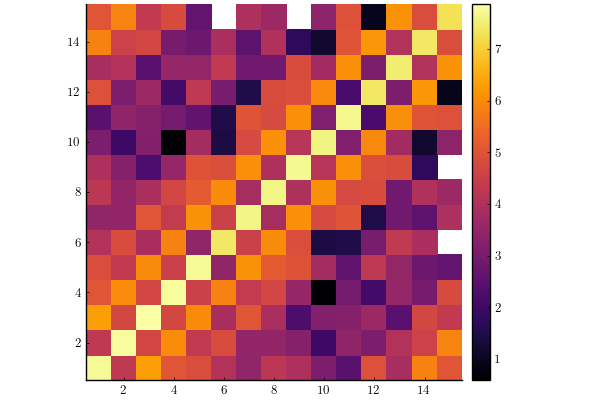

In [149]:
heatmap(collect(1:Nx), collect(1:Nx), log10.(Ω), ratio = 1)